In [1]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

In [2]:
# data_dir = '../algonauts_2023_challenge_data'
# parent_submission_dir = 'algonauts_2023_challenge_submission'
data_dir = "/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/dataset"
parent_submission_dir =  "/fsx/proj-medarc/fmri/dweisberg/fMRI-Algonauts-Challenge-2023/algonauts_2023_challenge_submission"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

subj = 1 

device: cuda


In [3]:
class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):
    
    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)

args = argObj(data_dir, parent_submission_dir, subj)

In [4]:
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)


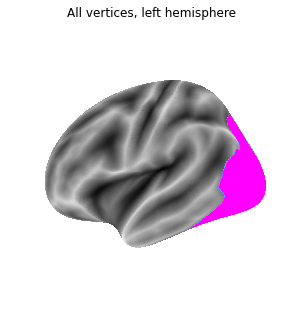

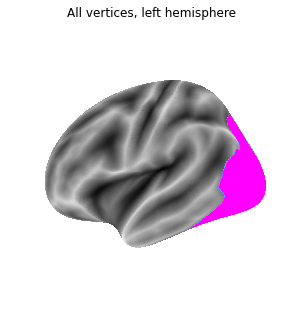

In [5]:
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)
zero = np.zeros(163842)
zero[:10000]=1
# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage', data_dir='/scratch/gpfs/dw26')
plotting.plot_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_all_vertices,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title='All vertices, '+hemisphere+' hemisphere'
    )

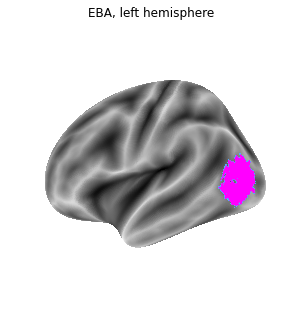

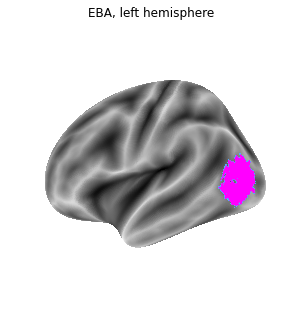

In [6]:
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage', data_dir='/scratch/gpfs/dw26')
plotting.plot_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_roi,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title=roi+', '+hemisphere+' hemisphere'
    )

In [7]:
print(fsaverage_all_vertices.shape) # all visually responsive vertices marked with 1's out of all vertices on brain
print(sum(fsaverage_all_vertices)) # should be vertices that are visually responsive
print(fsaverage_roi_class.shape) # class indices of all vertices
print(fsaverage_roi.shape) # vertices as 1's that are in the ROI
print(roi_map)

(163842,)
19004
(163842,)
(163842,)
{0: 'Unknown', 1: 'EBA', 2: 'FBA-1', 3: 'FBA-2', 4: 'mTL-bodies'}


In [8]:
train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

Training images: 9841
Test images: 159


In [9]:
train_img_file = train_img_list[0]
print('Training image file name: ' + train_img_file)
print('73k NSD images ID: ' + train_img_file[-9:-4])

Training image file name: train-0001_nsd-00013.png
73k NSD images ID: 00013


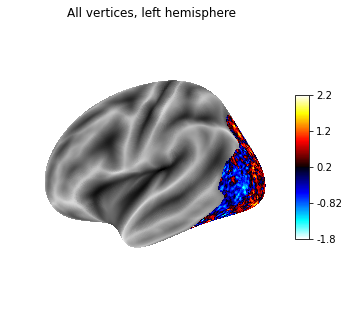

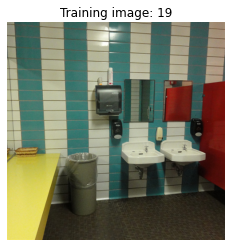

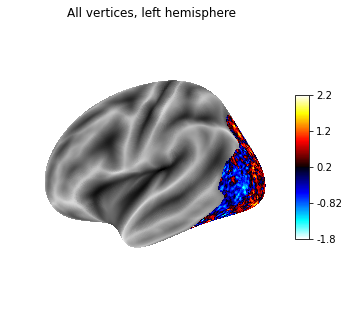

In [10]:
img = 18 #@param
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the image
img_dir = os.path.join(train_img_dir, train_img_list[img])
train_img = Image.open(img_dir).convert('RGB')

# Plot the image
plt.figure()
plt.axis('off')
plt.imshow(train_img)
plt.title('Training image: ' + str(img+1));

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the fMRI data onto the brain surface map
fsaverage_response = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_response[np.where(fsaverage_all_vertices)[0]] = lh_fmri[img]
elif hemisphere == 'right':
    fsaverage_response[np.where(fsaverage_all_vertices)[0]] = rh_fmri[img]

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage', data_dir = '/scratch/gpfs/dw26')
plotting.plot_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_response,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title='All vertices, '+hemisphere+' hemisphere'
    )

(163842,)


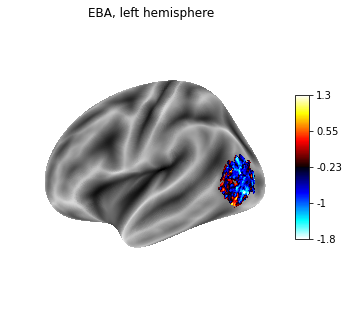

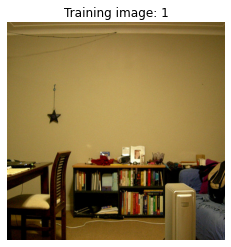

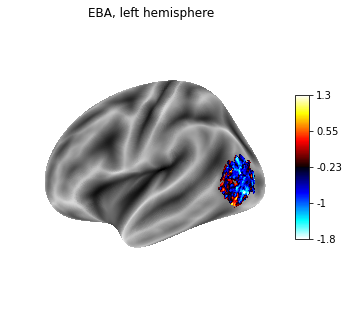

In [11]:
img = 0 #@param
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Load the image
img_dir = os.path.join(train_img_dir, train_img_list[img])
train_img = Image.open(img_dir).convert('RGB')

# Plot the image
plt.figure()
plt.axis('off')
plt.imshow(train_img)
plt.title('Training image: ' + str(img+1));

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)
print(fsaverage_roi.shape)
# Map the fMRI data onto the brain surface map
# fsaverage_response = np.zeros(len(fsaverage_roi))
# if hemisphere == 'left':
#     fsaverage_response[np.where(fsaverage_roi)[0]] = \
#         lh_fmri[img,np.where(challenge_roi)[0]]
# elif hemisphere == 'right':
#     fsaverage_response[np.where(fsaverage_roi)[0]] = \
#         rh_fmri[img,np.where(challenge_roi)[0]]
fsaverage_response = np.zeros(len(fsaverage_roi))
if hemisphere == 'left':
    fsaverage_response[np.where(fsaverage_all_vertices)[0]] = \
        lh_fmri[img]
elif hemisphere == 'right':
    fsaverage_response[np.where(fsaverage_roi)[0]] = \
        rh_fmri[img]

fsaverage_response = np.array([fsaverage_response[i] if c!=0 else 0 for i, c in enumerate(fsaverage_roi)])

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage', data_dir = '/scratch/gpfs/dw26')
plotting.plot_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_response,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title=roi+', '+hemisphere+' hemisphere'
    )

In [12]:
rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

Training stimulus images: 8857

Validation stimulus images: 984

Test stimulus images: 159


In [13]:
transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])

In [14]:
class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img

In [15]:
batch_size = 300 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform), 
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform), 
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform), 
    batch_size=batch_size
)

In [16]:
lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

In [17]:
del lh_fmri, rh_fmri

In [18]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in /admin/home-dweisberg/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [20]:
model_layer = "features.2" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])

In [21]:
def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca

In [22]:
pca = fit_pca(feature_extractor, train_imgs_dataloader)

100%|██████████████████████████████████████████████████████████| 30/30 [03:54<00:00,  7.83s/it]


In [23]:
def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)

In [24]:
features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')

100%|████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.84s/it]


Training images features:
(8857, 100)
(Training stimulus images × PCA features)

Validation images features:
(984, 100)
(Validation stimulus images × PCA features)

Test images features:
(984, 100)
(Test stimulus images × PCA features)


In [25]:
del model, pca

In [26]:
# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)

In [27]:
# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

100%|█████████████████████████████████████████████████| 20544/20544 [00:01<00:00, 16386.14it/s]


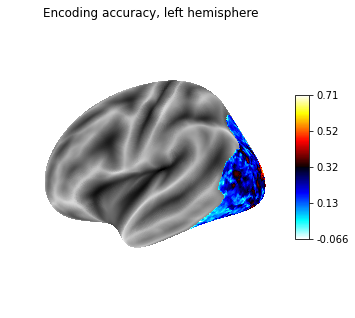

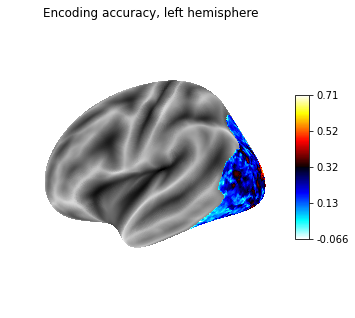

In [28]:
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation

# Create the interactive brain surface map
fsaverage = datasets.fetch_surf_fsaverage('fsaverage', data_dir = '/scratch/gpfs/dw26/')
plotting.plot_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_correlation,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title='Encoding accuracy, '+hemisphere+' hemisphere'
    )

Text(0.5, 1.0, 'Correlations by ROI')

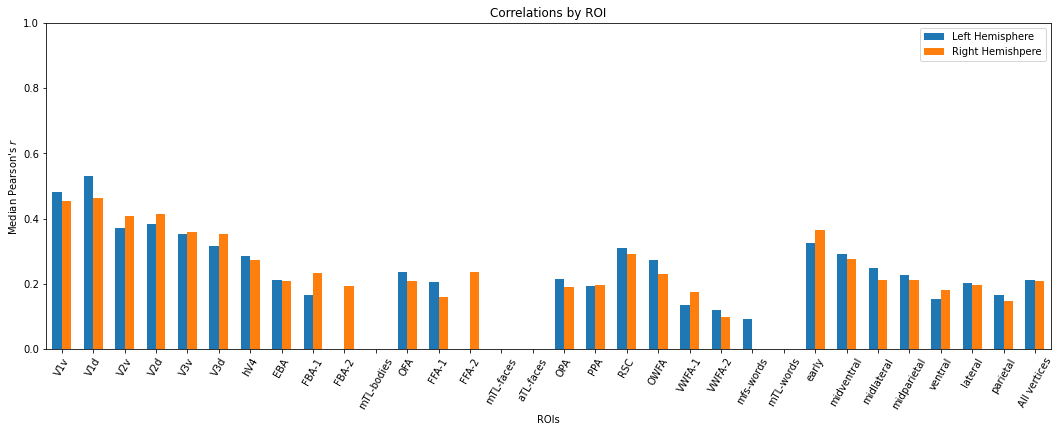

In [33]:
# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);
plt.title("Correlations by ROI")

In [30]:
lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

In [31]:
np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)